# Kernel Tuner Simulation Mode Test 2

This notebook is intended to examine the completeness in time and similarity in quality of solution of the simulation mode against a normal run. It consists of three simple steps:
- Do a live run with a cache file. 
- Do a simulation run. 
- The simulated run should have the same simulated total time as the live run, and should have the same quality of solution. 

In [1]:
from pathlib import Path
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from warnings import warn
from typing import Tuple

cachedirectory = Path("kernels/outputdata/simulation_mode")
savedirectory = Path(Path.cwd(), "figures", "simulation_mode")
mpl.rcParams["savefig.directory"] = savedirectory

In [2]:
# arguments
kernelname = "gemm_cltune_opencl"
expected_keys_env = ['execution_time', 'overhead_time', 'total_benchmark_time', 'total_verification_time', 'total_compile_time', 'total_strategy_time', 'total_framework_time']
expected_keys_cache = ['time', 'times', 'GFLOP/s', 'temperature', 'compile_time', 'benchmark_time', 'verification_time', 'framework_time', 'strategy_time']

algorithm_displaynames = {
    'brute': "bruteforce",
    'random': "random",
    'ordered': "ordered_greedy_mls",
}
mode_displaynames = {
    'simulated': 'simulated',
    'real': 'real',
    'realcached': 'realcached'
}
column_displaynames = {
    'compile_time': "Compile time",
    'benchmark_time': "Benchmark time",
    'verification_time': "Verification time",
    'strategy_time': "Strategy time",
    'framework_time': "Framework time",
    'total_time': "Total time"
}

plot_height = 6
plot_aspect = 2.0
plot_dpi = 250
sns.set_theme(rc={'figure.figsize':(plot_height*plot_aspect,plot_height)}, font_scale=1.2)

In [3]:
def get_dataframes(target_algorithm=None, fixed_fevals=True, fixed_seed=True, modes=['realcached', 'simulated'], stratify_modes=True) -> Tuple[pd.DataFrame, pd.DataFrame]:

    # collect the relevant cachefiles
    cachefiles : list[Path] = []
    for file in cachedirectory.iterdir():
        if file.is_file() and file.name.startswith(kernelname) and file.name.endswith('_output.json'):
            cachefiles.append(file)

    # create a list of dictionaries of the data
    cache_dicts = list()
    env_dicts = list()
    for filepath in cachefiles:
        # load the data
        envfilepath = Path(str(filepath).replace('_output', '_env'))
        assert envfilepath.exists()
        try:
            cachefile = json.load(filepath.open())
            envfile = json.load(envfilepath.open())
        except json.JSONDecodeError:
            warn(f"Could not load cachefile {filepath.name}")
            continue
        assert isinstance(cachefile, list)
        assert isinstance(envfile, dict)

        # combine the data into a dictionary
        device_name = envfile['device_name']
        is_simulated = "_mode=simulated" in filepath.name
        mode = mode_displaynames[re.search(r"_mode=([a-zA-Z]+)_", filepath.name).group(1).strip()]
        if mode not in modes:
            continue
        algorithm = algorithm_displaynames[re.search(r"_alg=([a-zA-Z]+)_", filepath.name).group(1).strip()]
        if target_algorithm is not None and not algorithm.startswith(target_algorithm):
            continue
        if fixed_fevals != ('_fixedfevals' in filepath.name):
            continue
        if fixed_seed != ('_fixedseed' in filepath.name):
            continue
        run_number = int(re.search(r"_#(\d+)_", filepath.name).group(1))
        # for each of the tuned configurations, create a dictionary with the expected items
        for value in cachefile:
            assert isinstance(value, dict)
            cache = {}
            cache['device_name'] = device_name
            cache['algorithm'] = algorithm
            cache['simulated'] = is_simulated
            cache['mode'] = mode
            cache['run_number'] = run_number
            for key in expected_keys_cache:
                cache[key] = value[key]
            cache['total_time'] = value['strategy_time'] + value['compile_time'] + value['benchmark_time'] + value['verification_time'] + value['framework_time']
            cache_dicts.append(cache)
        # create a global dictionary per tuning session
        env = {}
        env['device_name'] = device_name
        env['algorithm'] = algorithm
        env['simulated'] = is_simulated
        env['mode'] = mode
        env['number_of_configs'] = len(cachefile)
        env['run_number'] = run_number
        for key in expected_keys_env:
            env[key] = envfile[key]
        env_dicts.append(env)

    # create a dataframe out of the dictionaries
    df_cache = pd.DataFrame(cache_dicts)
    df_env = pd.DataFrame(env_dicts)

    # stratify the modes
    if stratify_modes:
        counts = df_cache['mode'].value_counts()
        min = counts.min()
        modes = df_cache['mode'].unique()
        for mode in df_cache['mode'].unique():
            count = counts[mode]
            if count != min:
                indices_to_drop = np.random.choice(df_cache.index[df_cache['mode'] == mode].tolist(), size=count-min)
                df_cache = df_cache.drop(index=indices_to_drop)
                print(f"Stratification: dropped {count-min} random rows of '{mode}' to equalize to {min} samples")

    # return the dataframes
    return df_cache, df_env

In [4]:
df_cache, df_env = get_dataframes(target_algorithm='ordered')
df_cache

Stratification: dropped 1 random rows of 'realcached' to equalize to 1142 samples


,device_name,algorithm,simulated,mode,run_number,time,times,GFLOP/s,temperature,compile_time,benchmark_time,verification_time,framework_time,strategy_time,total_time
0,NVIDIA RTX A4000,ordered_greedy_mls,True,simulated,0,57.760475,"[57.940991999999994, 57.868288, 57.503744, 57....",2380.044605,42.905569,72.787153,407.987943,0,0.137277,426.041031,906.953404
1,NVIDIA RTX A4000,ordered_greedy_mls,True,simulated,0,37.665499,"[37.789696, 37.516287999999996, 37.95660799999...",3649.825702,43.025244,145.230591,266.910333,0,0.146320,207.397765,619.685009
2,NVIDIA RTX A4000,ordered_greedy_mls,True,simulated,0,57.760475,"[57.940991999999994, 57.868288, 57.503744, 57....",2380.044605,42.905569,0.000000,0.000000,0,0.078838,10.541588,10.620426
3,NVIDIA RTX A4000,ordered_greedy_mls,True,simulated,0,60.449490,"[60.454879999999996, 60.449791999999995, 60.44...",2274.171498,45.043401,69.354905,427.526517,0,0.080690,0.006041,496.968152
4,NVIDIA RTX A4000,ordered_greedy_mls,True,simulated,0,35.451319,"[35.414016, 35.449856, 35.47136, 35.46112, 35....",3877.782614,45.583412,42.426547,251.373934,0,0.077607,0.004677,293.882765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,NVIDIA RTX A4000,ordered_greedy_mls,True,simulated,9,25.642715,"[25.765888, 25.708544, 25.542655999999997, 25....",5361.074504,63.663695,108.145492,182.571854,0,0.064023,0.012893,290.794263
2281,NVIDIA RTX A4000,ordered_greedy_mls,True,simulated,9,38.138587,"[38.144, 38.144, 38.135808, 38.136832, 38.1358...",3604.551641,63.825996,59.291480,273.309128,0,0.064699,0.013996,332.679303
2282,NVIDIA RTX A4000,ordered_greedy_mls,True,simulated,9,24.866231,"[24.876032, 24.871935999999998, 24.86476799999...",5528.481928,64.111942,98.804437,177.136036,0,0.063101,0.004867,276.008440
2283,NVIDIA RTX A4000,ordered_greedy_mls,True,simulated,9,21.268334,"[21.300224, 21.320704, 21.259263999999998, 21....",6463.717833,64.195325,77.243038,154.687313,0,0.063166,0.014428,232.007945


In [5]:
# fig = plt.gcf()
# fig.set_size_inches(9, plot_height)
# fig.set_dpi(plot_dpi)
# g = sns.countplot(data=df_cache, x='mode')
# g.set_ylabel("Number of configurations")
# g.bar_label(g.containers[0])
# plt.tight_layout()
# plt.savefig(savedirectory / "Q2_count")

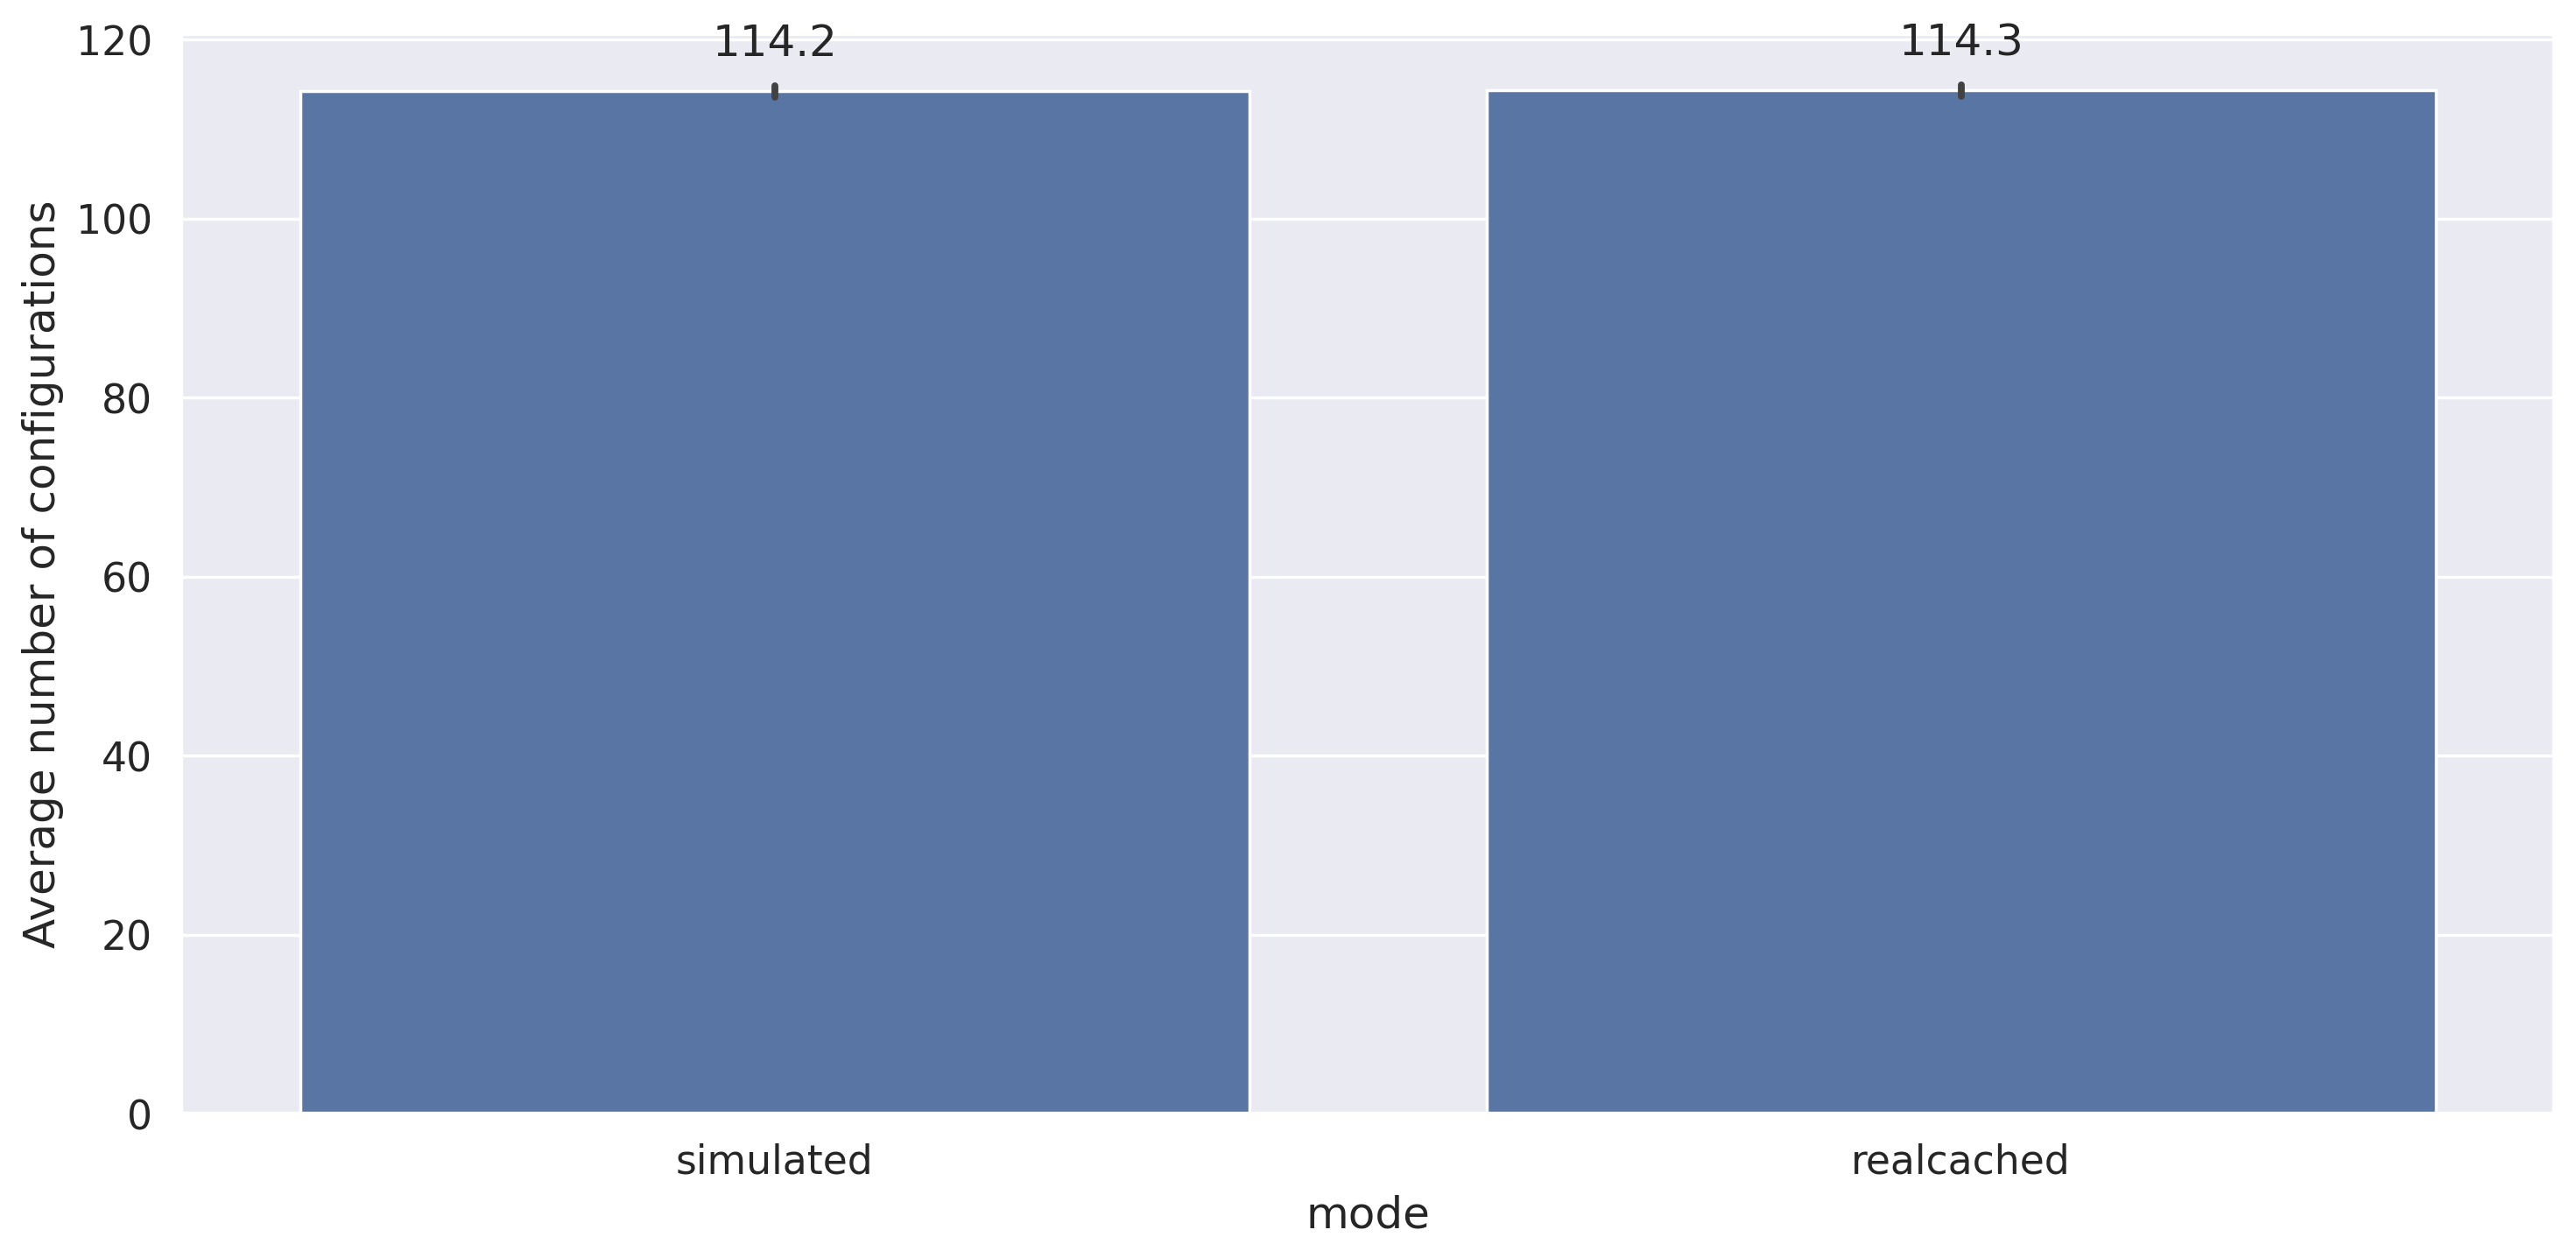

In [6]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=plot_dpi)
g = sns.barplot(data=df_env, x='mode', y='number_of_configs')
g.bar_label(g.containers[0], padding=9.0)
g.set_ylabel("Average number of configurations")
plt.tight_layout()
# plt.savefig(savedirectory / "Q2_count")

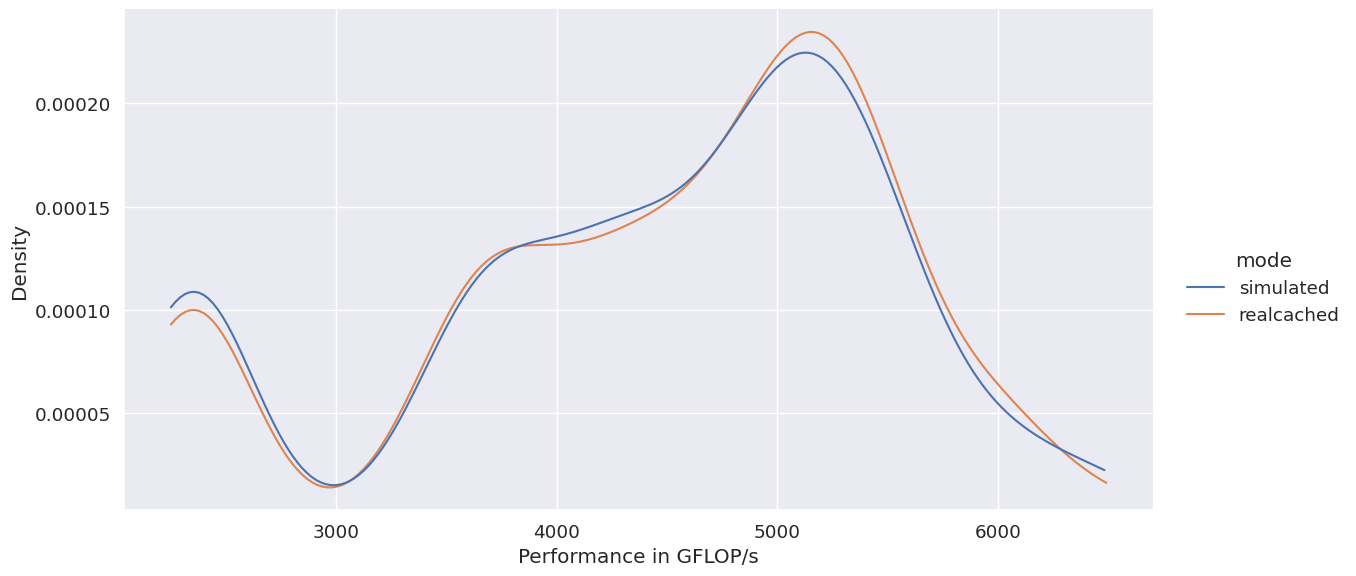

In [7]:
g = sns.displot(data=df_cache, x='GFLOP/s', hue='mode', kind='kde', fill=False, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Performance in GFLOP/s")
# g.savefig(savedirectory / "Q2_performance_gflops")

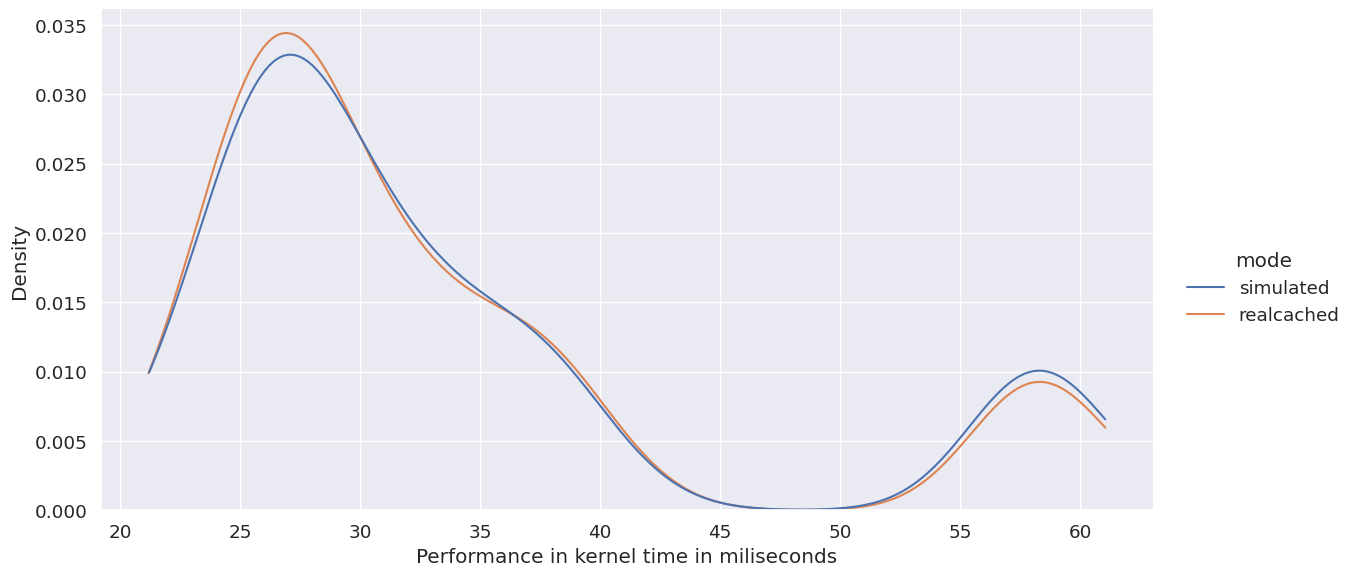

In [8]:
g = sns.displot(data=df_cache, x='time', hue='mode', kind='kde', fill=False, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Performance in kernel time in miliseconds")
# g.savefig(savedirectory / "Q2_performance_time")

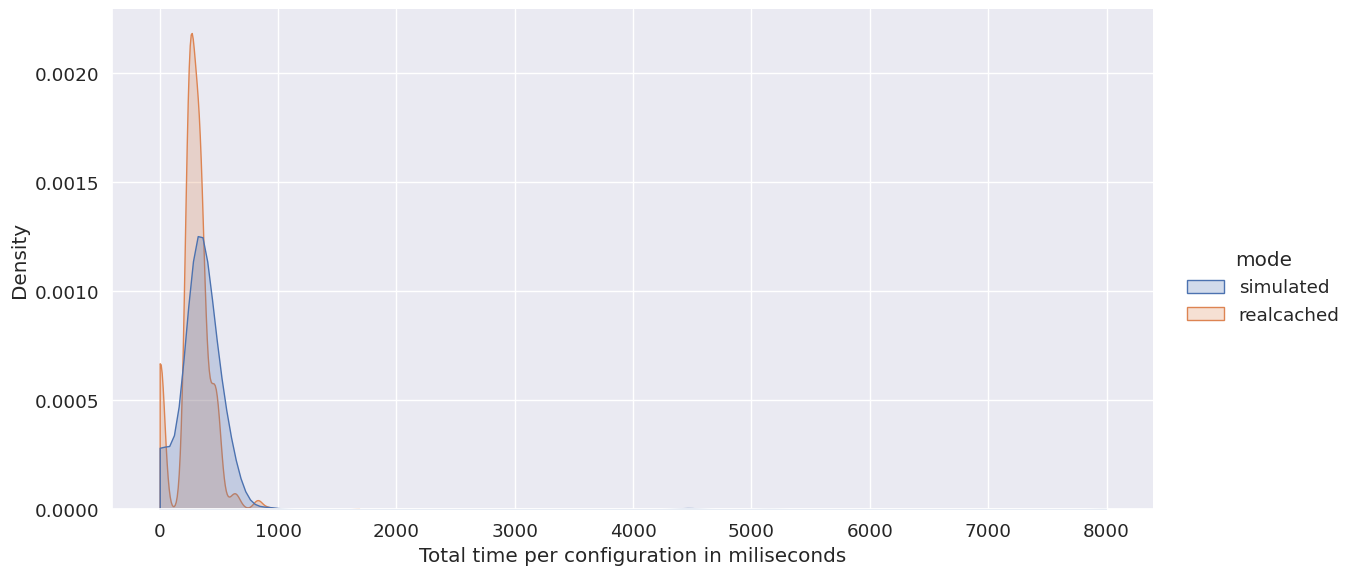

In [9]:
g = sns.displot(data=df_cache, x='total_time', hue='mode', kind='kde', fill=True, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Total time per configuration in miliseconds")
# g.savefig(savedirectory / "performance_distribution_time_per_config")

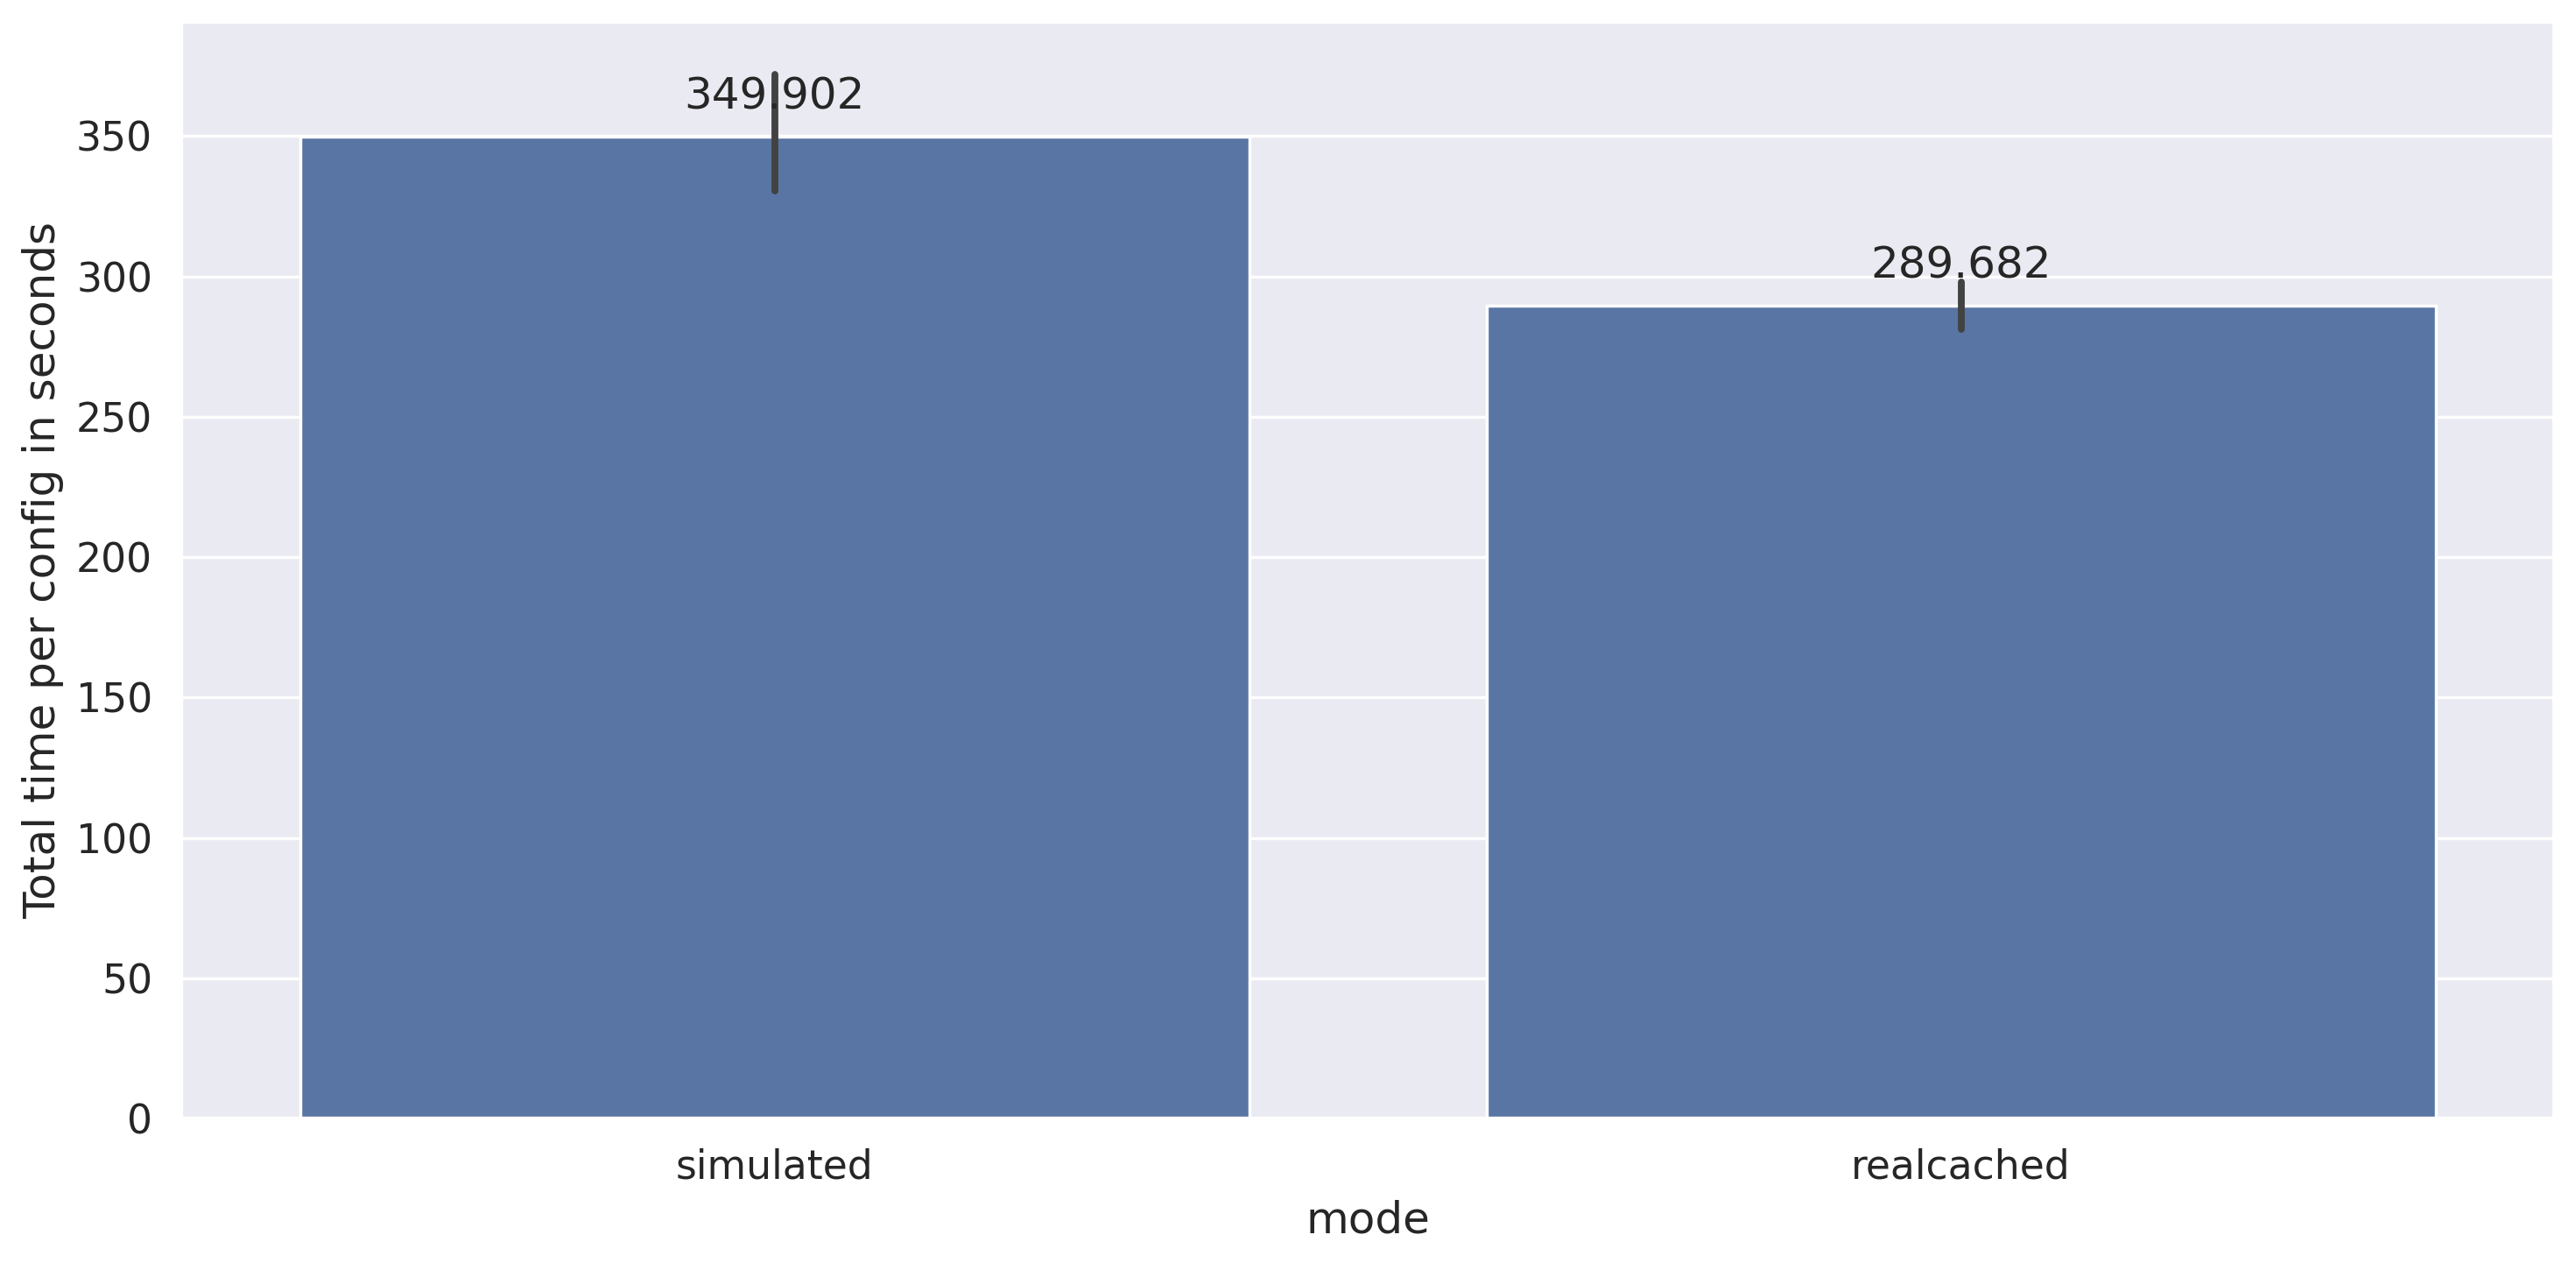

In [10]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=plot_dpi)
g = sns.barplot(data=df_cache.round(1), x='mode', y="total_time")
g.bar_label(g.containers[0], padding=6.0)
g.set_ylabel("Total time per config in seconds")
plt.tight_layout()
# plt.savefig(savedirectory / "Q3_total_time_spent")

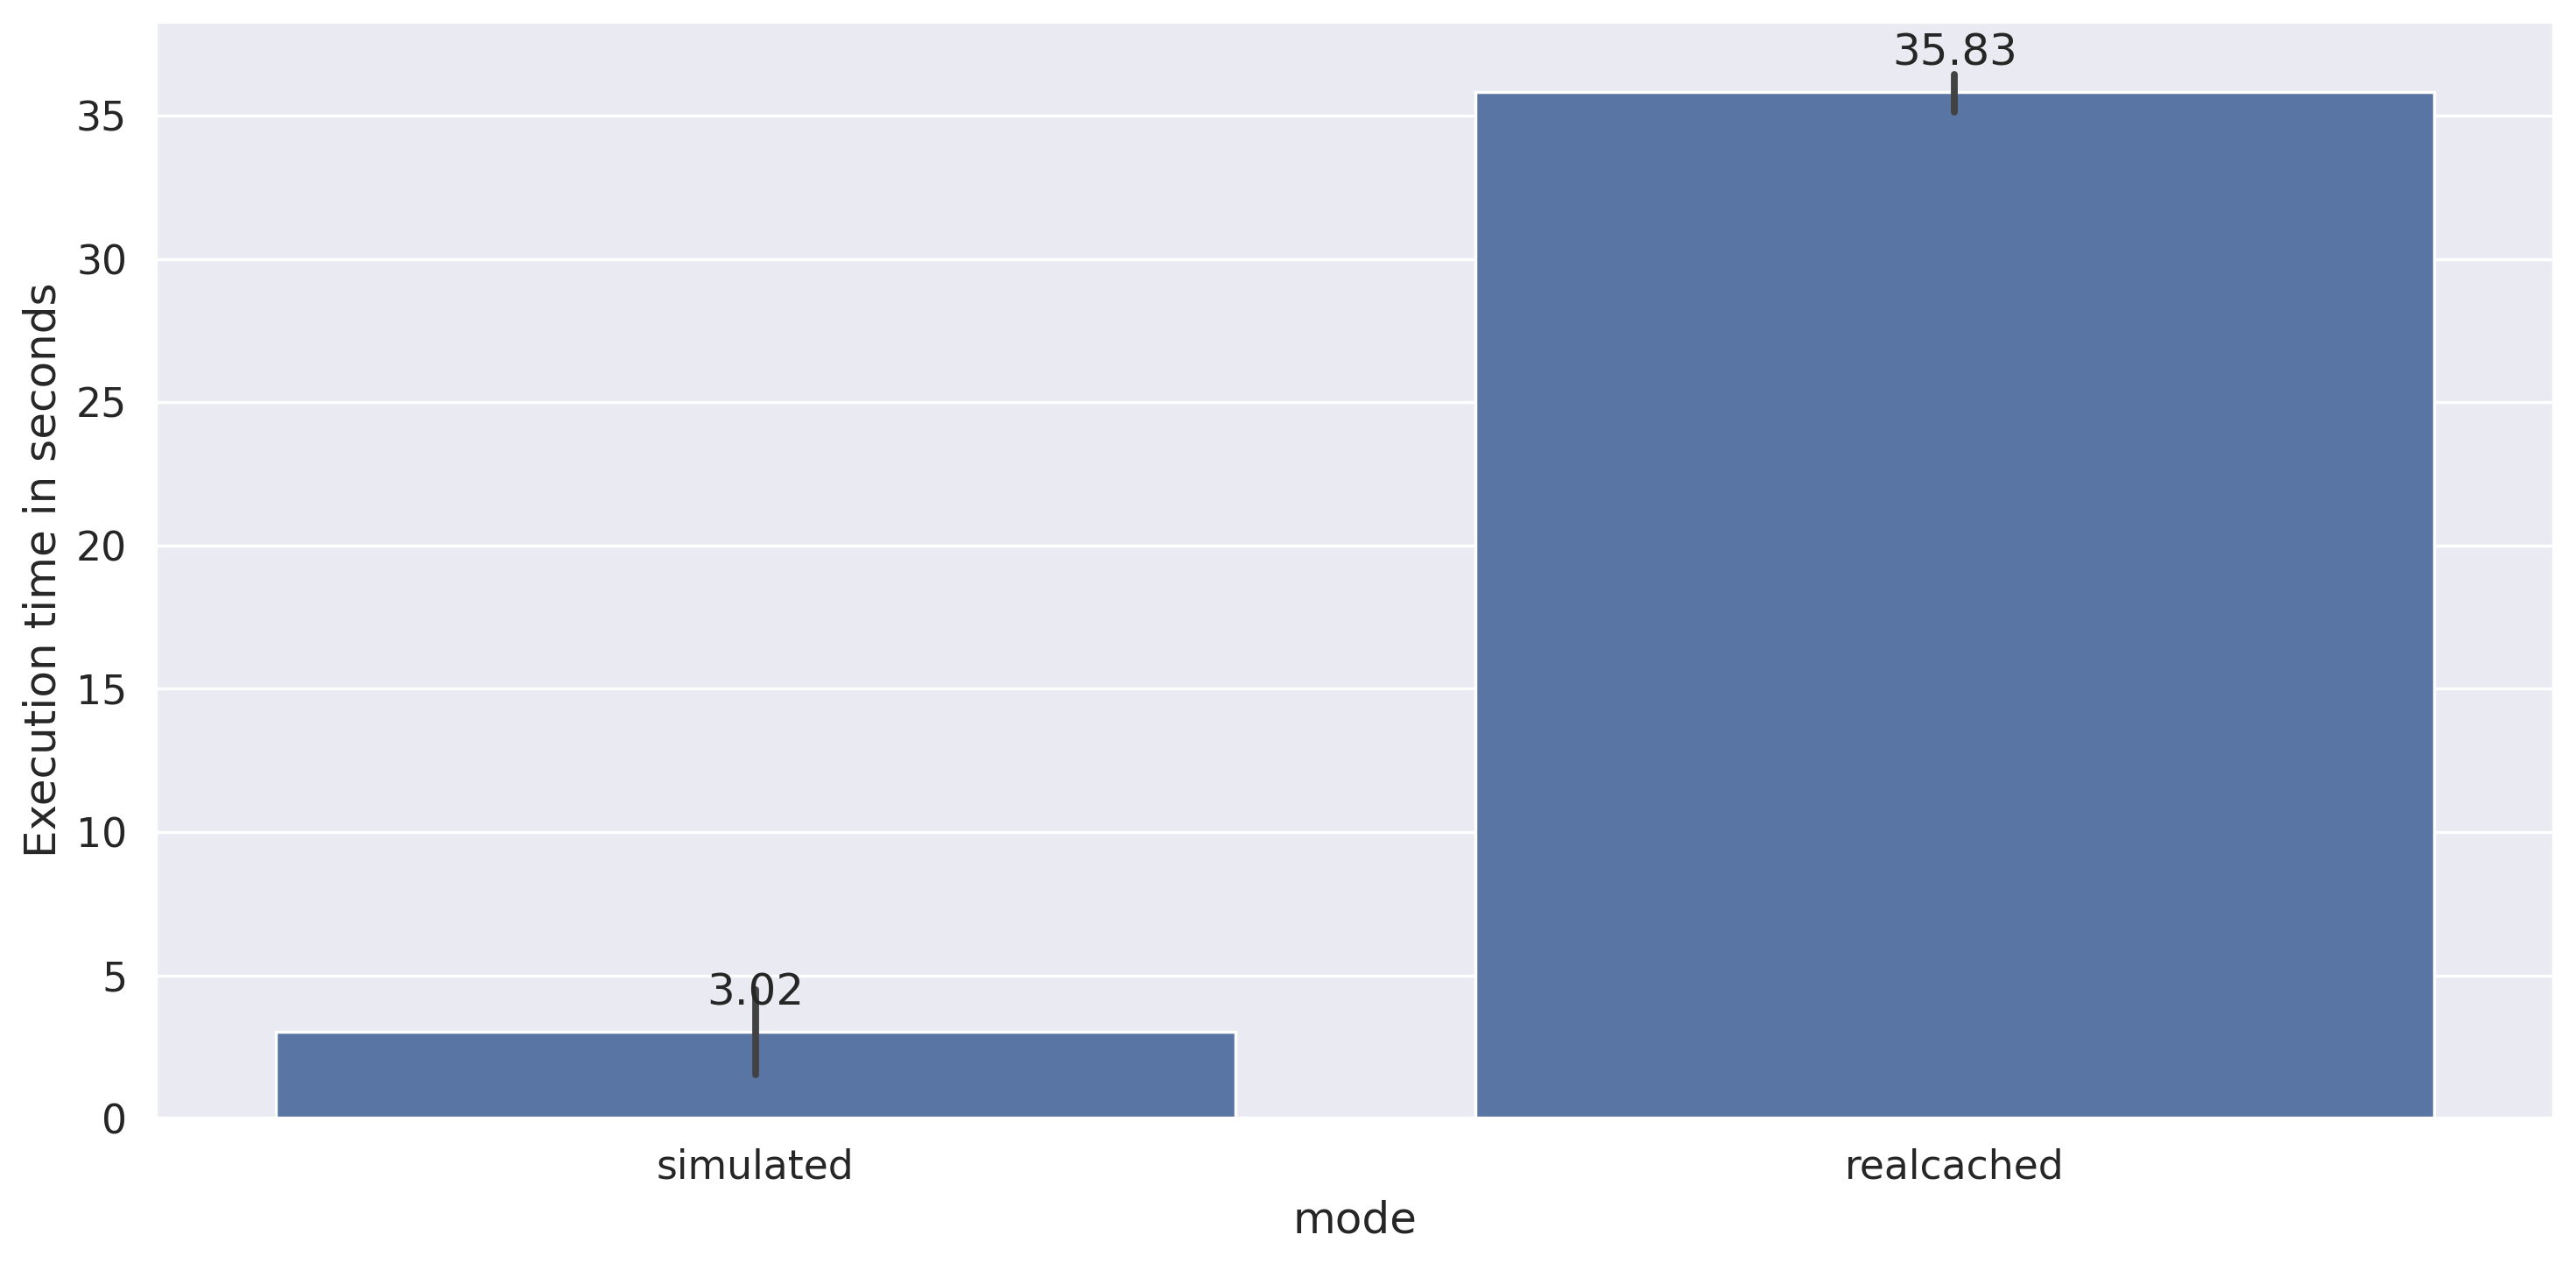

In [11]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=plot_dpi)
g = sns.barplot(data=df_env.round(1), x='mode', y="execution_time")
g.bar_label(g.containers[0], padding=6.0)
g.set_ylabel("Execution time in seconds")
plt.tight_layout()
# plt.savefig(savedirectory / "Q3_execution_time_spent")

            compile_time  benchmark_time  verification_time  framework_time  \
mode                                                                          
realcached     77.638367      203.950346                0.0        1.687121   
simulated     116.563863      208.044460                0.0        0.057682   

            strategy_time  
mode                       
realcached       6.407419  
simulated       25.239002  
            compile_time  benchmark_time  verification_time  framework_time  \
mode                                                                          
realcached     68.647385      101.475353                0.0        7.523894   
simulated      88.404923      104.900046                0.0        0.024596   

            strategy_time  
mode                       
realcached      39.587291  
simulated      326.808102  


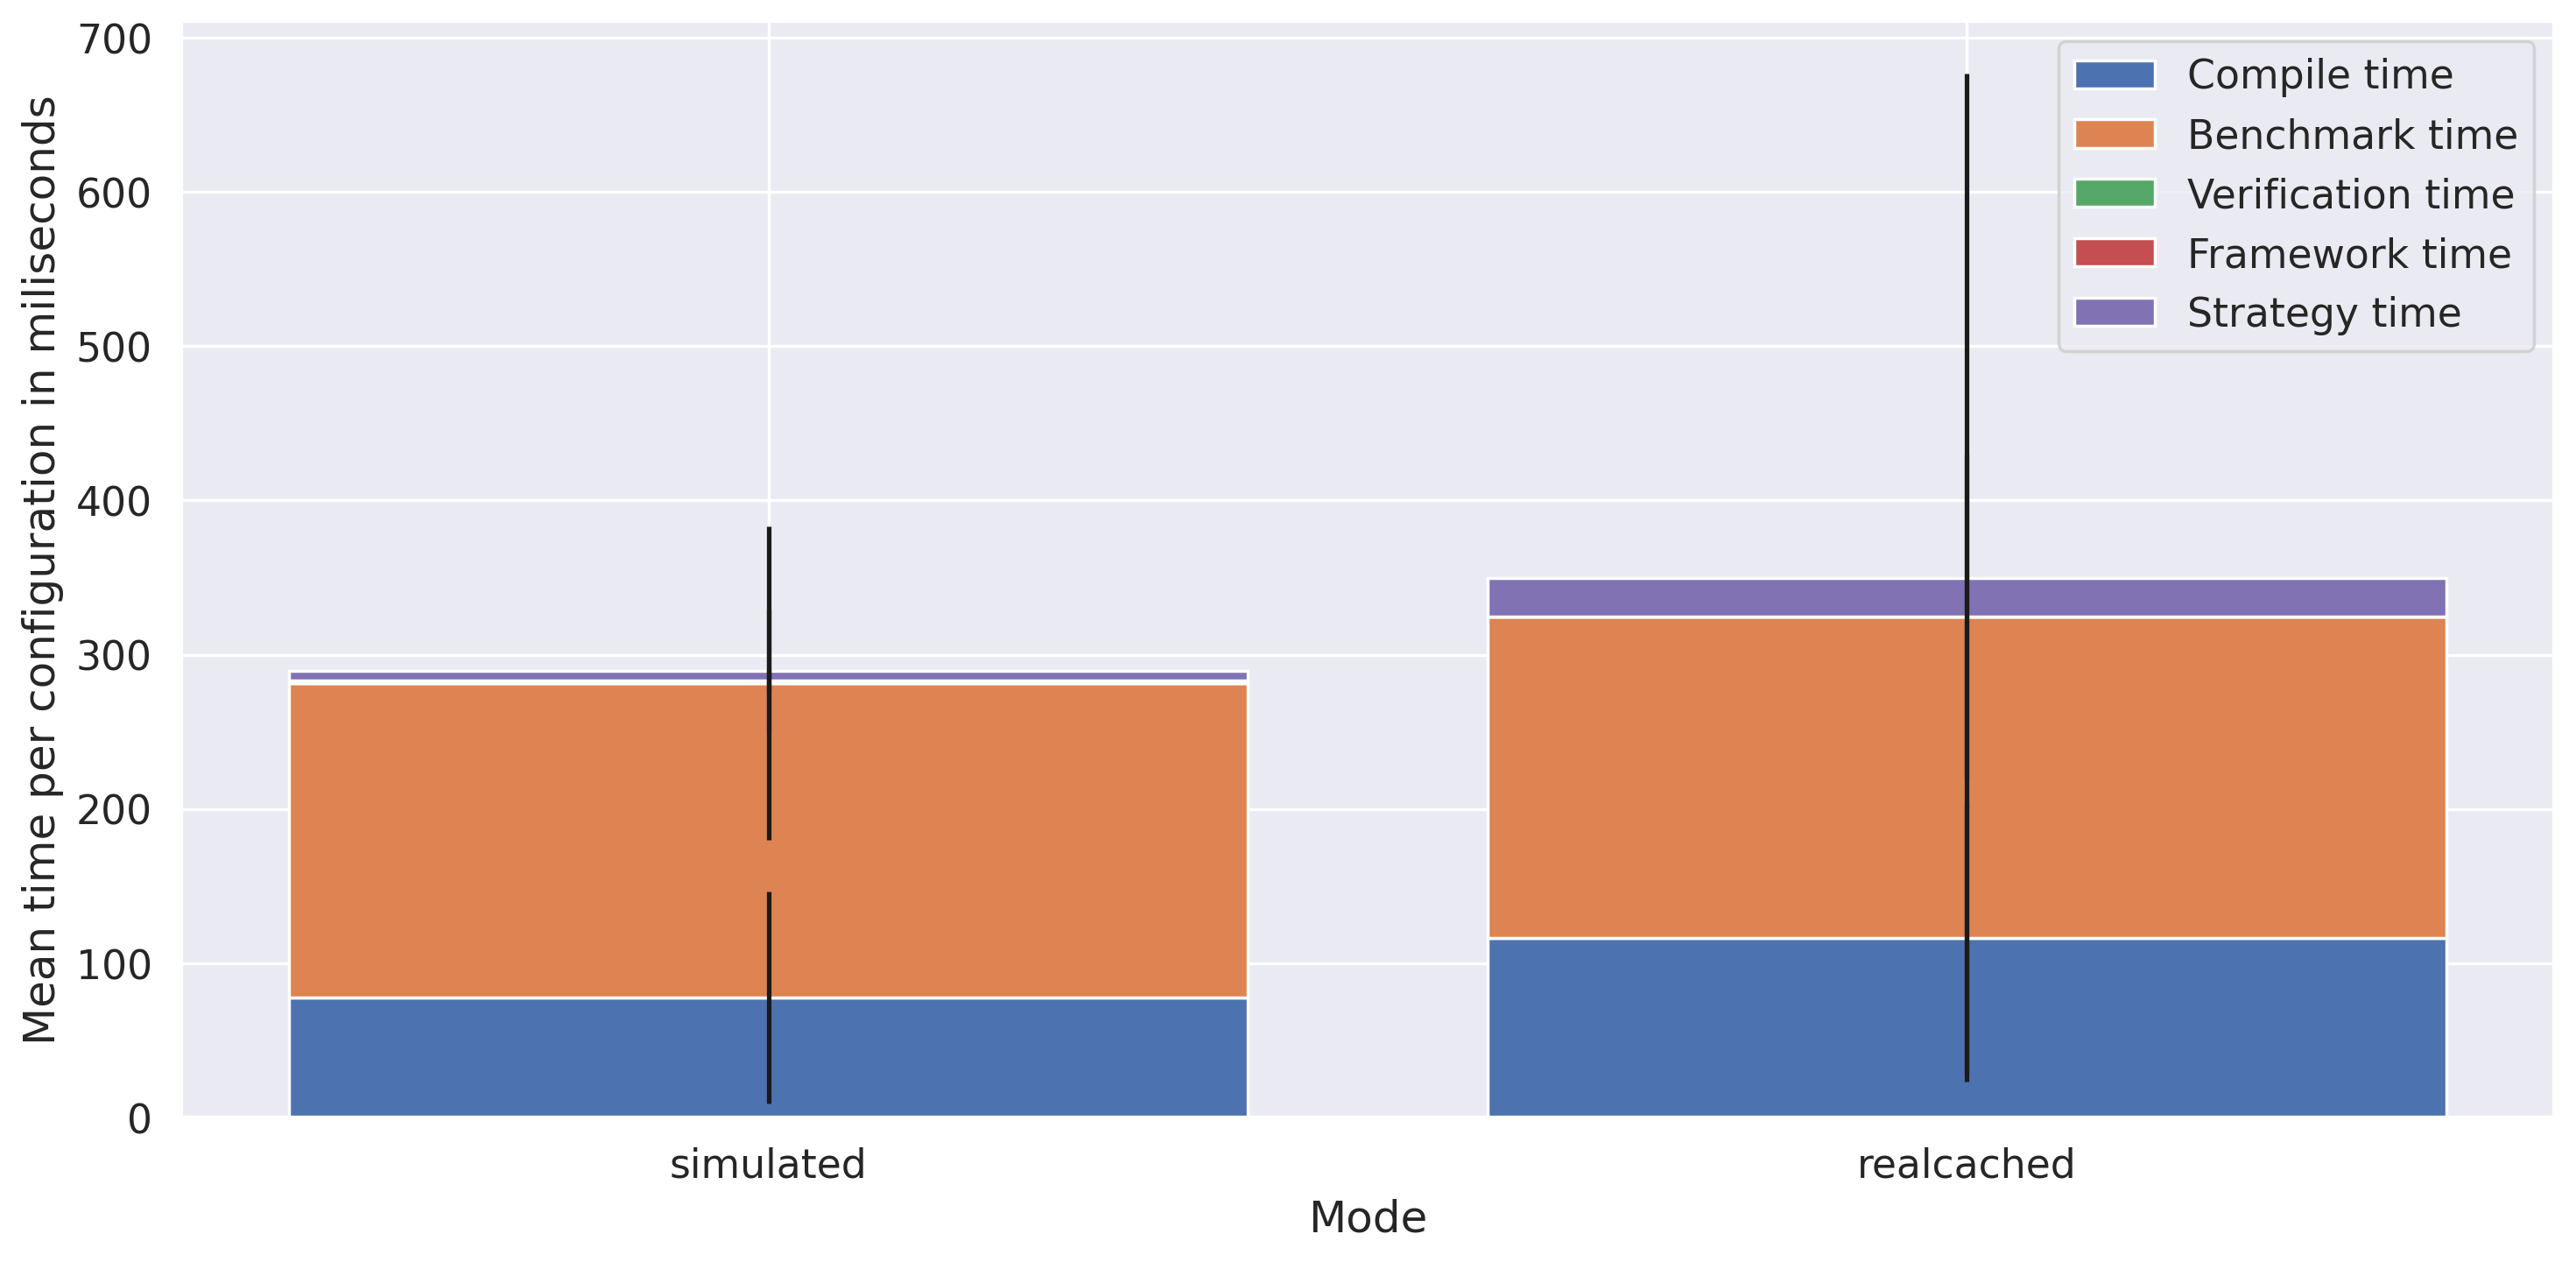

In [12]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=plot_dpi)
df_times = df_cache.filter(regex='_time|mode').drop(columns=['total_time'])
ind = df_times['mode'].unique()
prev = np.zeros(ind.shape)
times_avg = df_times.groupby('mode').mean()
times_std = df_times.groupby('mode').std()
print(times_avg)
print(times_std)
for series_name, _ in df_times.items():
    if '_time' in series_name:
        time_avg = np.array(times_avg[series_name])
        time_std = np.array(times_std[series_name])
        plt.bar(x=ind, height=time_avg, yerr=time_std, bottom=prev, label=column_displaynames[series_name])
        prev = time_avg + prev
plt.legend()
plt.xlabel("Mode")
plt.ylabel("Mean time per configuration in miliseconds")
plt.tight_layout()
# plt.savefig(savedirectory / "Q1_time_spent_per_category")